# Gaps on structure functions: demo of pipeline

- Inspired by existing code
- Test on one PSP to start, then two PSP and one Wind for training and testing
- Check against target dataframes as you go

### 0. Import dependencies

In [1]:
import pickle
import pandas as pd
import numpy as np
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.params as params
import src.sf_funcs as sf
import sys
import src.data_import_funcs as dif
import json
import glob
import importlib
import matplotlib.pyplot as plt
#plt.rcParams.update({"font.size": 16})
import matplotlib.dates as mdates

In [2]:
# For current Wind importing

sys_arg_dict = {
    # arg1
    "mag_path": params.mag_path,
    "proton_path": params.proton_path,
    "electron_path": params.electron_path,
    # arg2
    "mag_vars": [params.timestamp, params.Bwind, params.Bwind_vec],
    "proton_vars": [params.timestamp, params.np, params.Tp],
    "electron_vars": [params.timestamp, params.ne, params.Te],
    # arg3
    "mag_thresh": params.mag_thresh,
    "proton_thresh": params.proton_thresh,
    "electron_thresh": params.electron_thresh,
    # arg4
    "dt_hr": params.dt_hr,
    "int_size": params.int_size,
    # arg5
    "dt_lr": params.dt_lr,
}

### 1. Download files

Run in terminal

In [3]:
# For selecting a range of dates

# wget --no-clobber --directory-prefix=data/raw/psp  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_20181102{00..12}_v02.cdf
# wget --no-clobber --directory-prefix=data/raw/wind/ https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/2016/wi_h2_mfi_201601{01..07}_v05.cdf

# For entire folders

# wget --no-clobber --directory-prefix=data/raw/psp --recursive -np -nv -nH --cut-dirs=7 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
# wget --no-clobber --directory-prefix=data/raw/wind --recursive -np -nv -nH --cut-dirs=2 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/

### 2. Read in data and split into standardised intervals

#### PSP data

In [4]:
raw_file_list = sorted(glob.iglob("data/raw/psp/" + "/*.cdf"))
print(raw_file_list)

['data/raw/psp\\psp_fld_l2_mag_rtn_2018110200_v02.cdf', 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110206_v02.cdf', 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110212_v02.cdf']


In [5]:
psp_data = dif.read_cdfs(
    [raw_file_list[0]],  # LIMIT HERE!
    {"epoch_mag_RTN": (0), "psp_fld_l2_mag_RTN": (0, 3), "label_RTN": (0, 3)},
)
psp_data_ready = dif.extract_components(
    psp_data,
    var_name="psp_fld_l2_mag_RTN",
    label_name="label_RTN",
    time_var="epoch_mag_RTN",
    dim=3,
)
psp_df = pd.DataFrame(psp_data_ready)
psp_df["Time"] = pd.to_datetime("2000-01-01 12:00") + pd.to_timedelta(
    psp_df["epoch_mag_RTN"], unit="ns"
)
psp_df = psp_df.drop(columns="epoch_mag_RTN").set_index("Time")

df_raw = psp_df["B_R"]

print(df_raw.info())
print(df_raw.head())

reading file  data/raw/psp\psp_fld_l2_mag_rtn_2018110200_v02.cdf
Done reading data
<class 'pandas.core.series.Series'>
DatetimeIndex: 1582027 entries, 2018-11-02 00:01:09.195182976 to 2018-11-02 06:01:09.171900544
Series name: B_R
Non-Null Count    Dtype  
--------------    -----  
1582027 non-null  float64
dtypes: float64(1)
memory usage: 24.1 MB
None
Time
2018-11-02 00:01:09.195182976   -11.061315
2018-11-02 00:01:09.208836480   -10.854164
2018-11-02 00:01:09.222489856   -11.197883
2018-11-02 00:01:09.236143104   -11.008248
2018-11-02 00:01:09.249796352   -11.188342
Name: B_R, dtype: float64


#### Wind data
Takes a while due to large files

In [6]:
# raw_file_list = sorted(glob.iglob("data/raw/wind/" + "/*.cdf"))
# print(raw_file_list)

In [7]:
# df = utils.pipeline(
#     raw_file_list[0],
#     varlist=sys_arg_dict["mag_vars"],
#     thresholds=sys_arg_dict["mag_thresh"],
#     cadence=sys_arg_dict["dt_hr"],
# )

# print("Reading {0}: {1:.2f}% missing".format(raw_file_list[0], df.iloc[:,0].isna().sum()/len(df)*100))

# # Ensuring observations are in chronological order
# df_wind_hr = df.sort_index()

# # df_wind_hr = pd.read_pickle("data/processed/" + params.mag_path + params.dt_hr + ".pkl")
# df_wind_hr = df_wind_hr.rename(
#     columns={
#         params.Bwind: "Bwind",
#         params.Bx: "Bx",
#         params.By: "By",
#         params.Bz: "Bz",
#     }
# )

# missing = df_wind_hr.iloc[:, 0].isna().sum() / len(df_wind_hr)

# if missing > 0.4:
#     # Replacing values in lists with na
#     print("Large missing %")
# else:
#     int_wind_hr = df_wind_hr.interpolate().ffill().bfill()

# df_raw = int_wind_hr["Bx"]

# print(df_raw.info())
# print(df_raw.head())

In [8]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}\n".format(np.std(x)))

### 0PTIONAL CODE END ###

No missing data
Length of interval: 1582027
Duration of interval: 0 days 05:59:59.976717568
Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.24 Hz (2dp)
Mean = -28.383399058746512
Standard deviation = 18.777635215345533



In [9]:
times_to_gap = 2

In [10]:
tc_approx = 500  # s: 500 for PSP, 2000 for Wind
cadence_approx = 0.1  # s: 0.1 for PSP, 1 for Wind

tc_n = 10  # Number of actual (computed) correlation times we want in our standardised interval...
interval_length = 10000  # ...across this many points

df = df_raw.resample(str(cadence_approx) + "S").mean()

ints = []
tc_list = []
cadence_list = []

time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [df],
    nlags=10000,
    plot=False,
)

tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

if tc == -1:
    tc = tc_approx
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc not found for this interval, setting to 500s (default) -> cadence = {new_cadence}s"
    )

else:
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc calculated to be {np.round(tc,2)}s -> cadence = {np.round(new_cadence,2)}s (for {tc_n}tc across {interval_length} points)"
    )

tc_list.append(tc)
cadence_list.append(new_cadence)

try:
    interval_approx_resampled = df.resample(
        str(np.round(new_cadence, 3)) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        # Check if interval is complete
        if interval.isnull().sum() > 0:
            print("interval contains missing data even after down-sampling; skipping")
            # Note: due to merging cannot identify specific file with missing data here
            # only file list as here:
            # print("corresponding input file list: ", file_list_split[core])
        else:
            # print("Interval successfully processed")
            int_norm = utils.normalize(interval)
            ints.append(int_norm)

except Exception as e:
    print(f"An error occurred: {e}")

if len(ints) == 0:
    print("No good inputs found (ints is empty). Exiting.")
    exit(1)

# Logarithmically-spaced lags?
# vals = np.logspace(0, 3, 0.25 * len(ints[0]))
# lags = np.unique(vals.astype(int))
lags = np.arange(1, 0.25 * len(ints[0]))
powers = [0.5, 2]

print(
    "\nNumber of standardised intervals: ",
    len(ints),
    "about to be gapped",
    times_to_gap,
    "times",
)

tc calculated to be 736.2s -> cadence = 0.74s (for 10tc across 10000 points)

Number of standardised intervals:  2 about to be gapped 2 times


In [11]:
# Delete original dataframes
del psp_data, psp_data_ready, psp_df, df_raw

Text(0, 0.5, '$B_R$ (nT)')

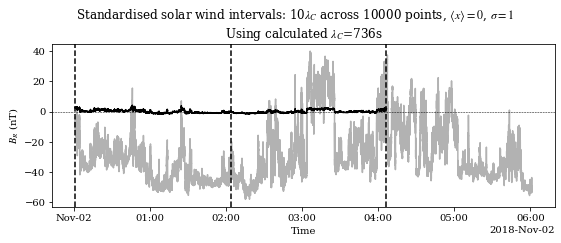

In [12]:
fig, ax = plt.subplots(figsize=(9, 3))
plt.plot(df, alpha=0.3, c="black")
plt.axvline(df.index[0], c="black", linestyle="dashed")
[
    plt.axvline(interval.index[-1], c="black", linestyle="dashed")
    for interval in ints
]
[plt.plot(interval, c="black") for interval in ints]
plt.axhline(0, c="black", linewidth=0.5, linestyle="--")
plt.suptitle(
    f"Standardised solar wind intervals: {tc_n}$\lambda_C$ across {interval_length} points, $\langle x \\rangle=0$, $\sigma=1$", y= 1.05
)
# # Add subtitle
plt.title(f"Using calculated $\lambda_C$={int(tc)}s")

# ax.set_xlim(interval_list_approx[0].index[0], interval_list_approx[2].index[-1])
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel("$B_R$ (nT)")
# Tidy the timestamp x-axis
# plt.xticks(rotation=20)

# plt.savefig("plots/int_standardised_demo.png")

In [13]:
raw_ints_meta = pd.DataFrame({
    "raw_int_start": df.index[0],
    "raw_int_end": df.index[-1],
    "tc": tc_list,
    "cadence": cadence_list,
})
raw_ints_meta

,raw_int_start,raw_int_end,tc,cadence
0,2018-11-02 00:01:09.100,2018-11-02 06:01:09.100,736.199,0.736199


In [14]:
ints_meta = pd.DataFrame({
    "int_start": [interval.index[0] for interval in ints],
    "int_end": [interval.index[-1] for interval in ints],
})
ints_meta.reset_index(inplace=True)
ints_meta.rename(columns={"index": "int_index"}, inplace=True)
ints_meta

,int_index,int_start,int_end
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712
1,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712


### 3. Calculate the true SF and slope for each interval

In [15]:
lags = np.arange(1, 0.1 * len(ints[0]))
powers = [2]

In [16]:
sfs = pd.DataFrame()

for i, input in enumerate(ints):
    # print(f"\nCore {core} processing standardised interval {i}")
    good_output, slope = sf.compute_sf(pd.DataFrame(input), lags, powers, False, False, [10,100])
    
    good_output.insert(0, "int_index", i)
    sfs = pd.concat([sfs, good_output])
    ints_meta.loc[ints_meta["int_index"]==i, "slope"] = slope

sfs.head()

,int_index,lag,n,missing_percent,sf_2,sf_2_se
1.0,0,1.0,9999,0.0,0.015702,0.000594
2.0,0,2.0,9998,0.0,0.032877,0.001324
3.0,0,3.0,9997,0.0,0.047024,0.001895
4.0,0,4.0,9996,0.0,0.059901,0.002304
5.0,0,5.0,9995,0.0,0.071729,0.002690


[]

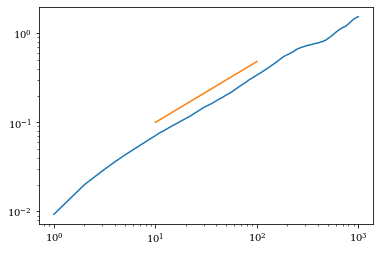

In [17]:
from src.data_import_funcs import pltpwrl
plt.plot(sfs.loc[sfs["int_index"]==1, "lag"], sfs.loc[sfs["int_index"]==1, "sf_2"])
pltpwrl(10,0.1, 10, 100, ints_meta.loc[ints_meta["int_index"]==1, "slope"].values)
plt.semilogx()
plt.semilogy()

Briefly limiting to processing single interval

### 4. Duplicate, gap and interpolate intervals, and calculate SFs and slopes

In [18]:
minimum_missing_chunks = 0.7

In [19]:
index_list = []
version_list = []
handling_list = []
missing_list = []
slopes_list = []

sfs_copies = pd.DataFrame()
ints_copies = pd.DataFrame()

for index in range(len(ints)):
    input = ints[index]

    for j in range(times_to_gap):
        total_removal = np.random.uniform(0, 0.95)
        ratio_removal = np.random.uniform(minimum_missing_chunks, 1)
        # print("Nominal total removal: {0:.1f}%".format(total_removal * 100))
        # print("Nominal ratio: {0:.1f}%".format(ratio_removal * 100))
        prop_remove_chunks = total_removal * ratio_removal
        prop_remove_unif = total_removal * (1 - ratio_removal)
        bad_input_temp, bad_input_ind, prop_removed = ts.remove_data(
            input, prop_remove_chunks, chunks=np.random.randint(1, 10)
        )
        bad_input, bad_input_ind, prop_removed = ts.remove_data(
            bad_input_temp, prop_remove_unif
        )
        if prop_removed >= 0.95 or prop_removed == 0:
            # print(">95% or 0% data removed, skipping")
            continue

        bad_output, slope = sf.compute_sf(pd.DataFrame(bad_input), lags, powers, False, False, [10,100])
        bad_output["int_index"] = index
        bad_output["version"] = j
        bad_output["gap_handling"] = "none"
        sfs_copies = pd.concat([sfs_copies, bad_output])

        for handling in ["none", "lint"]:
            index_list.append(index)
            version_list.append(j)
            missing_list.append(prop_removed*100)
            handling_list.append(handling)

            if handling == "none":
                slopes_list.append(slope)
                # Once we are done with computing the SF, add some metadata to the interval
                bad_input_df = pd.DataFrame(bad_input)
                bad_input_df.reset_index(inplace=True)
                bad_input_df["int_index"] = index
                bad_input_df["version"] = j
                bad_input_df["gap_handling"] = handling
                ints_copies = pd.concat([ints_copies, bad_input_df])

            elif handling == "lint":
                interp_input = bad_input.interpolate(method="linear")
                interp_output, slope = sf.compute_sf(pd.DataFrame(interp_input), lags, powers, False, False, [10,100])
                slopes_list.append(slope)
                
                # # Once we are done with computing the SF, add some metadata to the interval
                interp_input_df = pd.DataFrame(interp_input)
                interp_input_df.reset_index(inplace=True)
                interp_input_df["int_index"] = index
                interp_input_df["version"] = j
                interp_input_df["gap_handling"] = handling
                ints_copies = pd.concat([ints_copies, interp_input_df])

                interp_output["int_index"] = index
                interp_output["version"] = j
                interp_output["gap_handling"] = handling
                
                # Correcting sample size and uncertainty for linear interpolation, same values as no handling
                interp_output["missing_percent"] = bad_output["missing_percent"]
                interp_output["sf_2_se"] = bad_output["sf_2_se"]

                sfs_copies = pd.concat([sfs_copies, interp_output])

In [20]:
ints_copies_meta = pd.DataFrame({"int_index": index_list, "version": version_list, "missing_percent_overall": missing_list, "gap_handling": handling_list, "slope": slopes_list})

### 5. Calculate errors relative to true values

Join original and copies dataframes and do column operation

In [21]:
ints_copies_meta = pd.merge(ints_meta, ints_copies_meta, how="inner", on="int_index", suffixes=("_orig", ""))
ints_copies_meta["slope_pe"] = (ints_copies_meta["slope"] - ints_copies_meta["slope_orig"]) / ints_copies_meta["slope_orig"] * 100
ints_copies_meta["slope_ape"] = np.abs(ints_copies_meta["slope_pe"])

In [22]:
sfs_copies

,lag,n,missing_percent,sf_2,sf_2_se,int_index,version,gap_handling
1.0,1.0,6828,31.713171,0.017987,0.000801,0,0,none
2.0,2.0,6821,31.776355,0.037487,0.001816,0,0,none
3.0,3.0,6814,31.839552,0.053396,0.002604,0,0,none
4.0,4.0,6808,31.892757,0.067991,0.003163,0,0,none
5.0,5.0,6800,31.965983,0.080999,0.003666,0,0,none
...,...,...,...,...,...,...,...,...
995.0,995.0,9005,60.666297,1.255456,0.030265,1,1,lint
996.0,996.0,9004,60.706353,1.256437,0.030282,1,1,lint
997.0,997.0,9003,60.701988,1.257614,0.030286,1,1,lint
998.0,998.0,9002,60.664297,1.258661,0.030315,1,1,lint


In [23]:
sfs_copies = pd.merge(sfs, sfs_copies, how="inner", on=["int_index", "lag"], suffixes=("_orig", ""))
sfs_copies["sf_2_pe"] = (sfs_copies["sf_2"] - sfs_copies["sf_2_orig"]) / sfs_copies["sf_2_orig"] * 100

Calculate MAPE for each interval copy

In [24]:
for i in range(len(ints)):
    for j in range(times_to_gap):
        for gap_handling in ["none", "lint"]:
            mape = np.mean(np.abs(sfs_copies.loc[(sfs_copies["int_index"]==i) & (sfs_copies["version"]==j) & (sfs_copies["gap_handling"]==gap_handling), "sf_2_pe"]))
            ints_copies_meta.loc[(ints_copies_meta["int_index"]==i) & (ints_copies_meta["version"]==j) & (ints_copies_meta["gap_handling"]==gap_handling), "mape"] = mape

### 6. For PSP training set, create 2D and 3D heatmaps and export

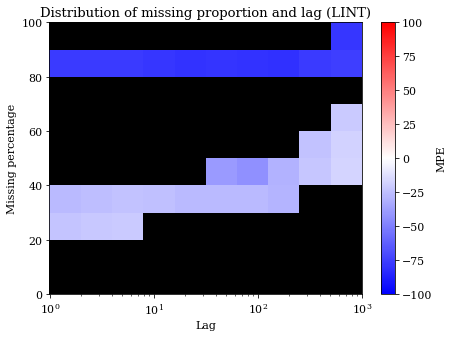

In [25]:
importlib.reload(sf)

missing_measure = "missing_percent"
n_bins = 10

heatmap_bin_vals_2d, heatmap_bin_edges_2d, lookup_table_2d = (
    sf.create_heatmap_lookup(
        sfs_copies[sfs_copies["gap_handling"]=="lint"], missing_measure, n_bins, log=True
    )
)

fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(
    heatmap_bin_edges_2d[0],
    heatmap_bin_edges_2d[1],
    heatmap_bin_vals_2d.T,
    cmap="bwr",
)
plt.colorbar(label="MPE")
plt.clim(-100, 100)
plt.xlabel("Lag")
plt.ylabel("Missing percentage")
plt.title("Distribution of missing proportion and lag (LINT)")
ax.set_facecolor("black")
ax.set_xscale("log")

In [26]:
lookup_table_2d.head()

,lag,missing_percent,mpe,mpe_sd,pe_min,pe_max,scaling,scaling_lower,scaling_upper
0,1.487531,25.0,-23.288082,0.000000,-23.288082,-23.288082,1.303578,1.303578,1.303578
1,1.487531,35.0,-26.654227,5.344309,-31.998536,-21.309918,1.363405,1.270808,1.470557
2,1.487531,85.0,-76.654977,0.000000,-76.654977,-76.654977,4.283568,4.283568,4.283568
3,2.977669,25.0,-21.393413,0.447309,-21.840721,-20.946104,1.272158,1.264960,1.279439
4,2.977669,35.0,-25.435523,3.841843,-29.789560,-21.499610,1.341121,1.273879,1.424290


In [27]:
heatmap_bin_vals_3d, heatmap_bin_edges_3d, lookup_table_3d = (
    sf.create_heatmap_lookup_3D(
        sfs_copies[sfs_copies["gap_handling"]=="lint"], missing_measure, n_bins, True
    )
)

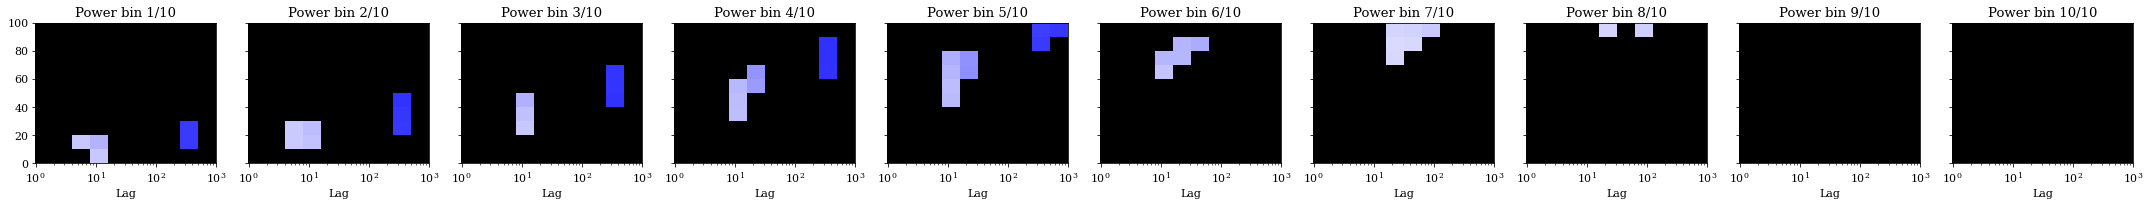

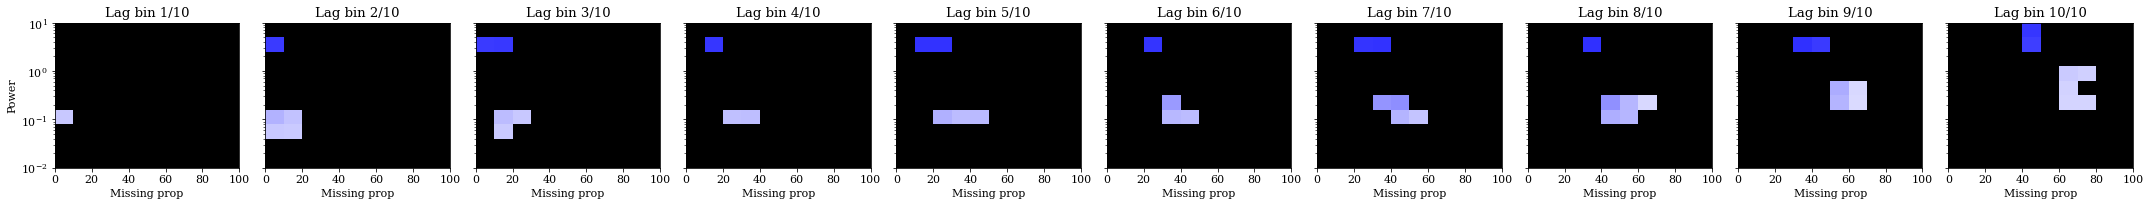

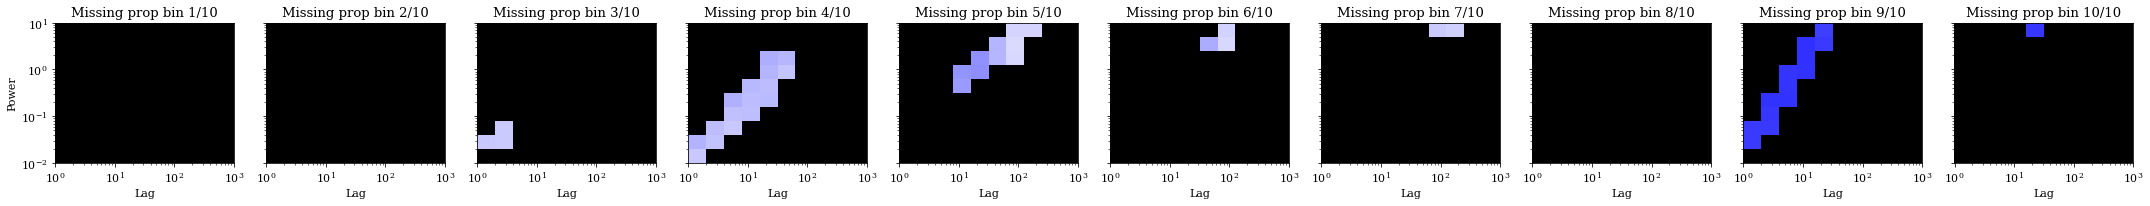

In [28]:
# Plotting 3D heatmaps

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[1],
        heatmap_bin_vals_3d[:, :, i],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.xlabel("Lag")
    plt.ylabel("Missing proportion")
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].set_title(
        f"Power bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Lag")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
#plt.savefig(save_dir + f"error_heatmap_b_{n_bins}_3d_power.png")
#plt.close()

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[1],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[i, :, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    ax[i].set_xlabel("Missing prop")
    ax[i].set_ylabel("Power")
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogy()
    ax[i].set_title(
        f"Lag bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Missing prop")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
#plt.savefig(save_dir + f"error_heatmap_b_{n_bins}_3d_lag.png")
#plt.close()

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[:, i, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].semilogy()
    ax[i].set_title(
        f"Missing prop bin {i+1}/{n_bins}".format(
            np.round(heatmap_bin_edges_3d[2][i], 2)
        )
    )
    ax[i].set_xlabel("Lag")
    ax[i].set_ylabel("Power")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
#plt.savefig(save_dir + f"error_heatmap_b_{n_bins}_3d_missing.png")
#plt.close()


In [29]:
lookup_table_3d.head()

,lag,missing_percent,sf_2,mpe,mpe_sd,pe_min,pe_max,scaling,scaling_lower,scaling_upper
0,1.487531,35.0,0.014976,-21.309918,0.000000,-21.309918,-21.309918,1.270808,1.270808,1.270808
1,2.977669,25.0,0.014976,-21.840721,0.000000,-21.840721,-21.840721,1.279439,1.279439,1.279439
2,2.977669,25.0,0.029882,-20.946104,0.000000,-20.946104,-20.946104,1.264960,1.264960,1.264960
3,2.977669,35.0,0.014976,-29.789560,0.000000,-29.789560,-29.789560,1.424290,1.424290,1.424290
4,2.977669,35.0,0.029882,-23.984177,3.354708,-28.726645,-21.499610,1.315516,1.273879,1.403049


In [30]:
# Export the lookup table as a CSV
print("Exporting lookup table to CSV")
#lookup_table_3d.to_csv(save_dir + f"lookup_table_3d_b_{n_bins}.csv")

Exporting lookup table to CSV


### 7. For PSP and Wind test sets, apply the correction factor

In [31]:
importlib.reload(sf)

# Apply 2D and 3D scaling to test set, report avg errors
print(f"Correcting interpolated test set intervals using 2D error heatmap with {n_bins} bins")
sfs_copies_corrected = sf.compute_scaling(
    sfs_copies[sfs_copies["gap_handling"]=="lint"], missing_measure, lookup_table_2d
)

Correcting interpolated test set intervals using 2D error heatmap with 10 bins


c:\Users\spann\Documents\Research\Code repos\time_series_analysis\src\sf_funcs.py:631: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_output["scaling"] = 1
c:\Users\spann\Documents\Research\Code repos\time_series_analysis\src\sf_funcs.py:632: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_output["scaling_lower"] = 1
c:\Users\spann\Documents\Research\Code repos\time_series_analysis\src\sf_funcs.py:633: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [32]:
# Apply 2D and 3D scaling to test set, report avg errors
print(f"Correcting interpolated test set intervals using 3D error heatmap with {n_bins} bins")
sfs_copies_corrected = sf.compute_scaling_3d(
    sfs_copies_corrected[sfs_copies_corrected["gap_handling"]=="lint"], missing_measure, lookup_table_3d
)

Correcting interpolated test set intervals using 3D error heatmap with 10 bins


In [33]:
sfs_copies_corrected

,int_index,lag,n_orig,missing_percent_orig,sf_2_orig,sf_2_se_orig,n,missing_percent,sf_2,sf_2_se,...,sf_2_upper_corrected_2d_smoothed,sf_2_corrected_3d,sf_2_lower_corrected_3d,sf_2_upper_corrected_3d,scaling_3d_smoothed,scaling_lower_3d_smoothed,scaling_upper_3d_smoothed,sf_2_corrected_3d_smoothed,sf_2_lower_corrected_3d_smoothed,sf_2_upper_corrected_3d_smoothed
1,0,1.0,9999,0.0,0.015702,0.000594,9999,31.713171,0.012356,0.000801,...,0.018170,0.015702,0.015702,0.015702,1.270808,1.270808,1.270808,0.015702,0.015702,0.015702
3,0,1.0,9999,0.0,0.015702,0.000594,9999,82.308231,0.003666,0.001281,...,0.010546,0.003666,0.003666,0.003666,1.135404,1.135404,1.135404,0.004162,0.004162,0.004162
5,0,2.0,9998,0.0,0.032877,0.001324,9998,31.776355,0.025808,0.001816,...,0.062153,0.025808,0.025808,0.025808,1.090269,1.090269,1.090269,0.028138,0.028138,0.028138
7,0,2.0,9998,0.0,0.032877,0.001324,9998,82.336467,0.007511,0.002477,...,0.021609,0.007511,0.007511,0.007511,1.067702,1.067702,1.067702,0.008019,0.008019,0.008019
9,0,3.0,9997,0.0,0.047024,0.001895,9997,31.839552,0.036807,0.002604,...,0.095202,0.048421,0.033595,0.086669,1.117265,1.036705,1.325096,0.041124,0.038158,0.048773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7983,1,997.0,9003,0.0,1.537439,0.021672,9003,60.701988,1.257614,0.030286,...,1.619846,1.585270,1.316682,1.991516,1.231316,1.000173,1.604975,1.548521,1.257832,2.018440
7985,1,998.0,9002,0.0,1.538456,0.021700,9002,46.945123,1.286007,0.028384,...,1.656416,1.545901,1.226051,2.091541,1.231316,1.000173,1.604975,1.583481,1.286229,2.064009
7987,1,998.0,9002,0.0,1.538456,0.021700,9002,60.664297,1.258661,0.030315,...,1.621194,1.586589,1.317778,1.993174,1.231316,1.000173,1.604975,1.549809,1.258879,2.020120
7989,1,999.0,9001,0.0,1.539483,0.021722,9001,46.894789,1.287362,0.028436,...,1.658162,1.547531,1.227343,2.093745,1.231316,1.000173,1.604975,1.585149,1.287585,2.066184


In [34]:
correction_wide =  sfs_copies_corrected[["int_index", "version", "lag", "sf_2_corrected_2d", "sf_2_corrected_3d"]]
correction_long = pd.wide_to_long(correction_wide, ["sf_2"], i=["int_index", "version", "lag"], j="gap_handling", sep="_", suffix=r"\w+")

In [35]:
correction_bounds_wide =  sfs_copies_corrected[["int_index", "version", "lag", "sf_2_lower_corrected_2d", "sf_2_lower_corrected_3d", "sf_2_upper_corrected_2d", "sf_2_upper_corrected_3d"]]
correction_bounds_long = pd.wide_to_long(correction_bounds_wide, ["sf_2_lower", "sf_2_upper"], i=["int_index", "version", "lag"], j="gap_handling", sep="_", suffix=r"\w+")

In [36]:
corrections_long = pd.merge(correction_long, correction_bounds_long, how="inner", on=["int_index", "version", "lag", "gap_handling"]).reset_index()

In [37]:
sfs_copies_small = sfs_copies[["int_index", "version", "gap_handling", "lag", "sf_2"]]
sfs_copies_small = sfs_copies_small.append(corrections_long)
sfs_copies_small = pd.merge(sfs, sfs_copies_small, how="inner", on=["int_index", "lag"], suffixes=("_orig", ""))

C:\Users\spann\AppData\Local\Temp\ipykernel_23868\3055313182.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sfs_copies_small = sfs_copies_small.append(corrections_long)


In [38]:
sfs_copies_small

,int_index,lag,n,missing_percent,sf_2_orig,sf_2_se,version,gap_handling,sf_2,sf_2_lower,sf_2_upper
0,0,1.0,9999,0.0,0.015702,0.000594,0,none,0.017987,NaN,NaN
1,0,1.0,9999,0.0,0.015702,0.000594,0,lint,0.012356,NaN,NaN
2,0,1.0,9999,0.0,0.015702,0.000594,1,none,0.018328,NaN,NaN
3,0,1.0,9999,0.0,0.015702,0.000594,1,lint,0.003666,NaN,NaN
4,0,1.0,9999,0.0,0.015702,0.000594,0,corrected_2d,0.016846,0.015702,0.018170
...,...,...,...,...,...,...,...,...,...,...,...
15979,1,999.0,9001,0.0,1.539483,0.021722,1,lint,1.259719,NaN,NaN
15980,1,999.0,9001,0.0,1.539483,0.021722,0,corrected_2d,1.547409,1.454077,1.600732
15981,1,999.0,9001,0.0,1.539483,0.021722,0,corrected_3d,1.547531,1.227343,2.093745
15982,1,999.0,9001,0.0,1.539483,0.021722,1,corrected_2d,1.587793,1.539483,1.678753


1. Training set needs errors before making corrections
2. Test set needs errors after applying corrections
3. Therefore, we may not need to perform this truncation followed by adding errors back in.

#### 7b. Calculate new slopes and MAPEs

In [39]:
sfs_copies_small["sf_2_pe"] = (sfs_copies_small["sf_2"] - sfs_copies_small["sf_2_orig"]) / sfs_copies_small["sf_2_orig"] * 100

In [40]:
i = 0 
j = 0
gap_handling = "lint"
ints_copies_meta[
                (ints_copies_meta["int_index"]==i) & 
                (ints_copies_meta["version"]==j) & 
                (ints_copies_meta["gap_handling"]=="corrected_2d")]

,int_index,int_start,int_end,slope_orig,version,missing_percent_overall,gap_handling,slope,slope_pe,slope_ape,mape


In [41]:
# Adding rows as placeholders for when we correct with 2D and 3D heatmaps and want to calculate errors

dup_df = ints_copies_meta.drop(["slope", "slope_pe", "slope_ape", "mape"], axis=1)
dup_df.replace(["none","lint"], ["corrected_2d", "corrected_3d"], inplace=True)
ints_copies_meta = pd.concat([ints_copies_meta, dup_df])
ints_copies_meta

,int_index,int_start,int_end,slope_orig,version,missing_percent_overall,gap_handling,slope,slope_pe,slope_ape,mape
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,31.26,none,0.654488,1.281558,1.281558,14.743570
1,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,31.26,lint,0.666914,3.204459,3.204459,16.686073
2,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,80.45,none,0.644263,-0.300747,0.300747,43.788052
3,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,80.45,lint,0.635240,-1.697035,1.697035,78.530795
4,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,25.59,none,0.607894,-10.963056,10.963056,17.656790
5,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,25.59,lint,0.602388,-11.769534,11.769534,20.381508
6,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,34.21,none,0.530965,-22.230717,22.230717,27.968424
7,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,34.21,lint,0.567990,-16.807605,16.807605,29.833404
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,31.26,corrected_2d,NaN,NaN,NaN,NaN
1,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,31.26,corrected_3d,NaN,NaN,NaN,NaN


In [42]:
for i in range(len(ints)):
    for j in range(times_to_gap):
        for gap_handling in ["none", "lint", "corrected_2d", "corrected_3d"]:
        # Calculate MAPE for 2D and 3D corrected SFs

            mape = np.mean(
                np.abs(
                    sfs_copies_small.loc[(sfs_copies_small["int_index"]==i) & 
                                    (sfs_copies_small["version"]==j) & 
                                    (sfs_copies_small["gap_handling"]==gap_handling), 
                                    "sf_2"]))
            
            ints_copies_meta.loc[
                (ints_copies_meta["int_index"]==i) & 
                (ints_copies_meta["version"]==j) & 
                (ints_copies_meta["gap_handling"]==gap_handling), 
                "mape"] = mape
            
            # Calculate power-law slope for 2D and 3D corrected SFs
            current_int = sfs_copies_small.loc[(sfs_copies_small["int_index"]==i) & 
                                (sfs_copies_small["version"]==j) & 
                                (sfs_copies_small["gap_handling"]==gap_handling)]

            pwrl_range = [10,100]
            # Fit a line to the log-log plot of the structure function over the given range
            min, max = pwrl_range[0], pwrl_range[1]

            slope = np.polyfit(
                np.log(current_int.loc[(current_int["lag"] >= 10) & (current_int["lag"] <= 100), "lag"]),
                np.log(current_int.loc[(current_int["lag"] >= 10) & (current_int["lag"] <= 100), "sf_2"]),
                1,
            )[0]


            ints_copies_meta.loc[
                (ints_copies_meta["int_index"]==i) & 
                (ints_copies_meta["version"]==j) & 
                (ints_copies_meta["gap_handling"]==gap_handling), 
                "slope"] = slope

In [43]:
ints_copies_meta

,int_index,int_start,int_end,slope_orig,version,missing_percent_overall,gap_handling,slope,slope_pe,slope_ape,mape
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,31.26,none,0.654488,1.281558,1.281558,0.998526
1,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,31.26,lint,0.666914,3.204459,3.204459,0.822066
2,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,80.45,none,0.644263,-0.300747,0.300747,1.475011
3,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,80.45,lint,0.635240,-1.697035,1.697035,0.209824
4,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,25.59,none,0.607894,-10.963056,10.963056,0.727618
5,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,25.59,lint,0.602388,-11.769534,11.769534,0.730334
6,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,34.21,none,0.530965,-22.230717,22.230717,0.644162
7,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,34.21,lint,0.567990,-16.807605,16.807605,0.662183
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,31.26,corrected_2d,0.674356,NaN,NaN,1.044687
1,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,31.26,corrected_3d,0.673334,NaN,NaN,1.005565


### 8. Again, calculate errors relative to true values

In [44]:
ints_copies_meta["slope_pe"] = (ints_copies_meta["slope"] - ints_copies_meta["slope_orig"]) / ints_copies_meta["slope_orig"] * 100
ints_copies_meta["slope_ape"] = np.abs(ints_copies_meta["slope_pe"])

### 8a. Overall dataset summary stats

In [45]:
ints_copies_meta

,int_index,int_start,int_end,slope_orig,version,missing_percent_overall,gap_handling,slope,slope_pe,slope_ape,mape
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,31.26,none,0.654488,1.281558,1.281558,0.998526
1,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,31.26,lint,0.666914,3.204459,3.204459,0.822066
2,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,80.45,none,0.644263,-0.300747,0.300747,1.475011
3,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,80.45,lint,0.635240,-1.697035,1.697035,0.209824
4,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,25.59,none,0.607894,-10.963056,10.963056,0.727618
5,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,25.59,lint,0.602388,-11.769534,11.769534,0.730334
6,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,34.21,none,0.530965,-22.230717,22.230717,0.644162
7,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,34.21,lint,0.567990,-16.807605,16.807605,0.662183
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,31.26,corrected_2d,0.674356,4.356170,4.356170,1.044687
1,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,31.26,corrected_3d,0.673334,4.197944,4.197944,1.005565


In [46]:
ints_copies_meta.groupby("gap_handling")[["missing_percent_overall", "slope", "slope_pe", "mape"]].agg(["mean", "median", "std", "min", "max"])

missing_percent_overall                                   \
                                mean  median        std    min    max   
gap_handling                                                            
corrected_2d                 42.8775  32.735  25.302452  25.59  80.45   
corrected_3d                 42.8775  32.735  25.302452  25.59  80.45   
lint                         42.8775  32.735  25.302452  25.59  80.45   
none                         42.8775  32.735  25.302452  25.59  80.45   

                 slope                                          slope_pe  \
                  mean    median       std       min       max      mean   
gap_handling                                                               
corrected_2d  0.669352  0.662634  0.055470  0.609830  0.742310  0.782339   
corrected_3d  0.669925  0.661582  0.042482  0.628974  0.727561  0.861941   
lint          0.618133  0.618814  0.042561  0.567990  0.666914 -6.767429   
none          0.609402  0.626078  0.055984  0.530965  0.654488 -8.053241   

                                                            mape            \
                median        std        min       max      mean    median   
gap_handling                                                                 
corrected_2d  2.542121   8.311178 -10.679456  8.724571  0.946044  0.940583   
corrected_3d  2.379405   6.326621  -7.875407  6.564360  0.931134  0.914037   
lint         -6.733284   9.146468 -16.807605  3.204459  0.606101  0.696258   
none         -5.631902  10.904242 -22.230717  1.281558  0.961329  0.863072   

                                            
                   std       min       max  
gap_handling                                
corrected_2d  0.080297  0.858323  1.044687  
corrected_3d  0.050807  0.890895  1.005565  
lint          0.272186  0.209824  0.822066  
none          0.374374  0.644162  1.475011

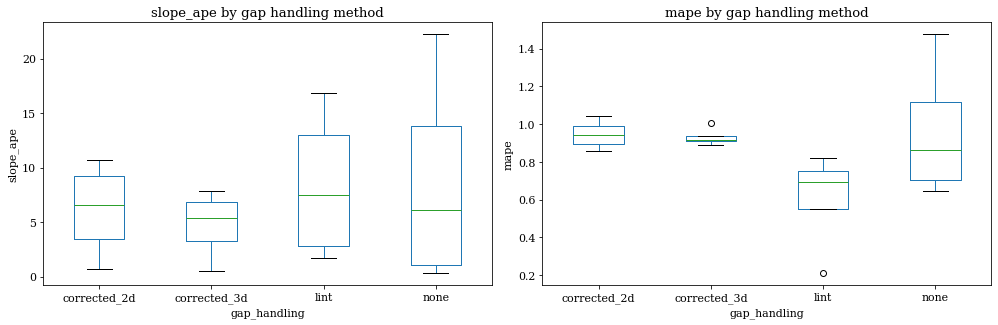

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming ints_copies_meta is your DataFrame
# Define the list of columns to plot
columns = ["slope_ape", "mape"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()

custom_order = ["none", "lint", "corrected_2d", "corrected_3d"]

# Create boxplots for each column
for col, ax in zip(columns, axes):
    ints_copies_meta.boxplot(column=col, by='gap_handling', ax=ax, grid=False)
    ax.set_title(f'{col} by gap handling method')
    ax.set_xlabel('gap_handling')
    ax.set_ylabel(f'{col}')

# Adjust layout
plt.tight_layout()
plt.suptitle('')  # Remove the default title to avoid overlap
plt.show()

# NEXT
1. Re-run DONE
2. Email Marcus
2. Finish current ad-hoc plots
3. Make target plots
4. Finalise relational database 
5. Run on 3 files
    - Figure out indexing of raw and processed int dfs
6. Run on a couple more dups maybe
7. Figure out train-test split, noting different stages of having errors in the respective dataframes
8. Thinking about splitting and reducing of data, turn into scripts with parallel capability.
9. Quick scaling study on NeSI, investigating bad ints
10. Results for 1 year of PSP, 1 month of Wind
10. Up the ante to two years, while writing up existing results.

### 8b. Check final dataframes

Look at Jupyter variables to confirm what we've got 

## 9. Producing target plots

KeyError: 'sf_2_corrected_2d'

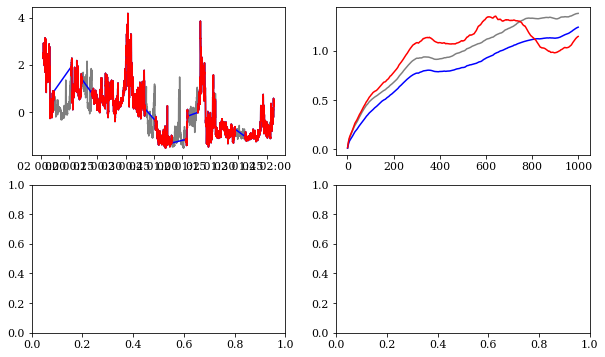

In [48]:
# # Quick check of results
index = 0
n_versions = 2

fig, ax = plt.subplots(n_versions, 2, figsize=(10, n_versions*3))
for i in range(n_versions):
    ax[i, 0].plot(ints[index], alpha=0.5, c="black")
    ax[i, 0].plot(
        ints_copies.loc[((ints_copies["int_index"]==index) & (ints_copies["gap_handling"]=="lint") & (ints_copies["version"]==i)),"Time"],
        ints_copies.loc[((ints_copies["int_index"]==index) & (ints_copies["gap_handling"]=="lint") & (ints_copies["version"]==i)),"B_R"], c="blue")
    ax[i, 0].plot(
        ints_copies.loc[((ints_copies["int_index"]==index) & (ints_copies["gap_handling"]=="none") & (ints_copies["version"]==i)),"Time"],
        ints_copies.loc[((ints_copies["int_index"]==index) & (ints_copies["gap_handling"]=="none") & (ints_copies["version"]==i)),"B_R"], c="red")

    ax[i, 1].plot(sfs.loc[sfs["int_index"]==index,"lag"],
                  sfs.loc[sfs["int_index"]==index,"sf_2"], 
                  alpha=0.5, 
                  c="black")
    ax[i, 1].plot(
        sfs_copies.loc[((sfs_copies["int_index"]==index) & (sfs_copies["gap_handling"]=="lint") & (sfs_copies["version"]==i)),"lag"],
        sfs_copies.loc[((sfs_copies["int_index"]==index) & (sfs_copies["gap_handling"]=="lint") & (sfs_copies["version"]==i)),"sf_2"], 
        c="blue")
    ax[i, 1].plot(
        sfs_copies.loc[((sfs_copies["int_index"]==index) & (sfs_copies["gap_handling"]=="none") & (sfs_copies["version"]==i)),"lag"],
        sfs_copies.loc[((sfs_copies["int_index"]==index) & (sfs_copies["gap_handling"]=="none") & (sfs_copies["version"]==i)),"sf_2"], 
        c="red")
    ax[i, 1].plot(
        sfs_copies.loc[((sfs_copies["int_index"]==index) & (sfs_copies["gap_handling"]=="lint") & (sfs_copies["version"]==i)),"lag"],
        sfs_copies.loc[((sfs_copies["int_index"]==index) & (sfs_copies["gap_handling"]=="lint") & (sfs_copies["version"]==i)),"sf_2_corrected_2d"], 
        c="purple")

    pltpwrl(10,0.1, 10, 100, ints_copies_meta.loc[((ints_copies_meta["int_index"]==index) & (ints_copies_meta["gap_handling"]=="none") & (ints_copies_meta["version"]==i)),"slope"].values, c="red", ax=ax[i, 1])
    pltpwrl(10,0.1, 10, 100, ints_copies_meta.loc[((ints_copies_meta["int_index"]==index) & (ints_copies_meta["gap_handling"]=="lint") & (ints_copies_meta["version"]==i)),"slope"].values, c="blue", ax=ax[i, 1])
    pltpwrl(10,0.1, 10, 100, ints_meta.loc[ints_meta["int_index"]==index,"slope"].values, ax=ax[i, 1], c="black")

    ax[i, 1].semilogx()
    ax[i, 1].semilogy()
#plt.savefig("data/processed/validation_plot.png")
#print("Validation plot saved")

[]

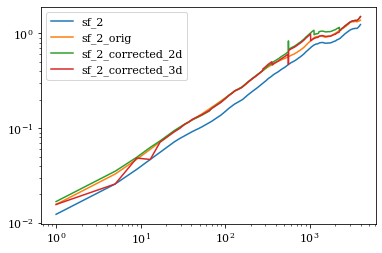

In [ ]:
sfs_copies[(sfs_copies["int_index"]==0) & (sfs_copies["version"]==0) & (sfs_copies["gap_handling"]=="lint")][["sf_2", "sf_2_orig", "sf_2_corrected_2d", "sf_2_corrected_3d"]].plot()
plt.semilogx()
plt.semilogy()

## 10. Running for multiple files and with training and test splits